## Поиск вхождений слов

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Similar_company/train_data.csv')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[['name_1', 'name_2']], df.is_duplicate, test_size=0.25, random_state=222, shuffle=True, stratify=df.is_duplicate)

In [ ]:
x_train.head()

,name_1,name_2
125504,HYDROTECH MEMBRANES,PUMA ENERGY ESPANA
273742,Dc Logistics,Suzhou Kintetsu Logistics Co Ltd
150308,Chand Engineering,Venus Engineering Co
199756,Shenzhen Green Sun Mould Co Ltd,Ncm International Co Ltd
395769,Thermwell Products Co,HR International


In [ ]:
x_train['is_duplicate'] = y_train

In [ ]:
df_for_tfidf = np.hstack([x_train.name_1.values, x_train.name_2.values])

In [ ]:
tfv = TfidfVectorizer(min_df=5, max_df=2000)
tfv.fit(df_for_tfidf)
# tf_idf_1 = tfv.transform(x_train.name_1)
# tf_idf_2 = tfv.transform(x_train.name_2)
dict_words = tfv.vocabulary_
key_words = dict_words.keys()

In [ ]:
def frequency_filter(df, key_words):
    labels = []
    for name_1, name_2, dub in df.values:
        n=0
        for word in name_1.lower().split():        
            if (word in key_words) and (word in name_2.lower().split()): 
                n+=1
        if n > 0:
            labels.append(1)
        else:
            labels.append(0)
    df['predict'] = labels
    return df

In [ ]:
df_after_tfidf = frequency_filter(x_train, key_words)

In [ ]:
def get_result(df):

    print('Всего отфильтрованных, как разные: ' , df.loc[df.predict==0, 'predict'].shape[0])
    print('Из них ошибочно отфильтрованы, как разные: ' , df.loc[(df.predict==0)&(df.is_duplicate==1)].shape[0])
    print()
    print('Всего отфильтрованных, как одинаковые: ' , df.loc[df.predict==1, 'predict'].shape[0])
    print('Из них правильно отфильтрованы, как одинаковые: ' , df.loc[(df.predict==1)&(df.is_duplicate==1)].shape[0])
    pass

In [ ]:
get_result(df_after_tfidf)

Всего отфильтрованных, как разные:  317023
Из них ошибочно отфильтрованы, как разные:  77

Всего отфильтрованных, как одинаковые:  13801
Из них правильно отфильтрованы, как одинаковые:  2261


In [ ]:
words=''
for name_1, name_2 in df_after_tfidf.loc[df_after_tfidf.predict==1, ['name_1', 'name_2']].values:
    words = words + name_1 + ' ' + name_2 + ' '

words = set(words.lower().split())

In [ ]:
def word_count_in_title(words, df, duplicate=True) -> dict:
    word_count_dict={}
    for word in words:
        cnt=0
        for company_name in df.loc[(df.predict==1)&(df.is_duplicate==duplicate), ['name_1']].values:
            company_name = company_name[0].lower().split()
            if word in company_name:
                cnt+=1
        word_count_dict[word] = cnt  
    return word_count_dict


dict_positive = word_count_in_title(words, df_after_tfidf)
dict_negative = word_count_in_title(words, df_after_tfidf, False)


In [ ]:
word_importance = {}
for word in words:
    try: 
        value = dict_positive[word] / (dict_positive[word] + dict_negative[word])
    except ZeroDivisionError: 
        value = 0
    word_importance[word] = value

In [ ]:
def filter_by_importance(df, dict_importance):
    labels=[]
    for name_1, name_2, dub, _ in df.loc[df.predict==1].values:
        n=0
        words = name_1.lower().split() 
        # max_value = np.argmax([dict_value[word] for word in i_name])  
        if (dict_importance.setdefault(words[0], 0) > 0.4) and (words[0] in name_2.lower().split()):
            n+=1
        else:
            for word in words[1:]:
                if (dict_importance.setdefault(words[0], 0) > 0.7) and (word in name_2.lower().split()):
                    n+=1

        if n>0:
            labels.append(1)
        else:
            labels.append(0)
    df.loc[df.predict==1, 'predict'] = labels

    return df

In [ ]:
df_with_predict = filter_by_importance(df_after_tfidf, word_importance)

In [ ]:
get_result(df_with_predict)

Всего отфильтрованных, как разные:  328542
Из них ошибочно отфильтрованы, как разные:  234

Всего отфильтрованных, как одинаковые:  2282
Из них правильно отфильтрованы, как одинаковые:  2104


In [ ]:
print('Precision: ', precision_score(df_with_predict['is_duplicate'], df_with_predict['predict']))
print('Recall: ', recall_score(df_with_predict['is_duplicate'], df_with_predict['predict']))

Precision:  0.9219982471516214
Recall:  0.8999144568006844


### Проверка на тестовой выборке

In [ ]:
x_test.head()

,name_1,name_2,is_duplicate,predict
165460,North American Wood Products,Iris Products SADe CV,0,0
196743,Gestion Soprema Canada Inc,VALLI ZABBAN,0,0
406708,Les Tricots Duval And Raymond,Tes Uk,0,0
30669,Ss Trade Inc,Foshan City Yi Si High Trade Co Ltd,0,0
323247,Hangzhou Industrial Co Ltd,Gti International Pvt Ltd,0,0


In [ ]:
x_test['is_duplicate'] = y_test

In [ ]:
test_after_tfidf = frequency_filter(x_test, key_words)

In [ ]:
get_result(test_after_tfidf)

Всего отфильтрованных, как разные:  105498
Из них ошибочно отфильтрованы, как разные:  39

Всего отфильтрованных, как одинаковые:  4777
Из них правильно отфильтрованы, как одинаковые:  741


In [ ]:
test_with_predict = filter_by_importance(test_after_tfidf, word_importance)

In [ ]:
get_result(test_with_predict)

Всего отфильтрованных, как разные:  4019
Из них ошибочно отфильтрованы, как разные:  64

Всего отфильтрованных, как одинаковые:  758
Из них правильно отфильтрованы, как одинаковые:  677


In [ ]:
print('Precision: ', precision_score(test_with_predict['is_duplicate'], test_with_predict['predict']))
print('Recall: ', recall_score(test_with_predict['is_duplicate'], test_with_predict['predict']))

Precision:  0.8931
Recall:  0.8679


## BERT

In [ ]:
!pip install pytorch-transformers

In [ ]:
import torch
from pytorch_transformers import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer 
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Similar_company/train_data.csv')

In [ ]:
df.head()

,name_1,name_2,is_duplicate
0,Texxon Chemicals Inc,AL,0
1,Morgan Polimer Seals S De Rl De Cv,Usa,0
2,Weiler,Shanghai Jixiang Automobile Roof Trimming Co Ltd,0
3,M Company NYSEMMM,ROGITEX,0
4,Hershey Trading Gmb H,MB,0


#### Undersampling обучающей выборки

In [ ]:
df_for_tfidf = np.hstack([df.name_1.values, df.name_2.values])

In [ ]:
tfv = TfidfVectorizer(min_df=5, max_df=2000)
tfv.fit(df_for_tfidf)
dict_words = tfv.vocabulary_
key_words = dict_words.keys()

In [ ]:
def frequency_filter(df, key_words):
    labels = []
    for name_1, name_2, dub in df.values:
        n=0
        for word in name_1.lower().split():        
            if (word in key_words) and (word in name_2.lower().split()): 
                n+=1
        if n > 0:
            labels.append(1)
        else:
            labels.append(0)
    df['predict'] = labels
    return df

In [ ]:
df_after_tfidf = frequency_filter(df, key_words)

In [ ]:
for_train = df.loc[df.is_duplicate==1, ['name_1', 'name_2', 'is_duplicate']]

In [ ]:
train = df_after_tfidf.loc[(df_after_tfidf.predict==1)&(df_after_tfidf.is_duplicate==0), ['name_1', 'name_2', 'is_duplicate']]

In [ ]:
train = train.append(for_train)

In [ ]:
# Перемешиваем выборку
train = train.sample(frac=1)

#### Получение эмбеддингов

In [ ]:
model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
train = train.sample(frac=1)

In [ ]:
# преобразуем каждое название в список токенов.

train_name_1 = train.iloc[:,0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
train_name_2 = train.iloc[:,1].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
train_name_1 = train_name_1.values
train_name_2 = train_name_2.values

In [ ]:
# преобразуем все списки к одному размеру.
train_1 = np.zeros((train.shape[0], 8))
for i, name in enumerate(train_name_1):
    if len(name) > 9:
        name = name[1:9]
        train_1[i, :len(name)] = name
    else:
        name = name[1:]
        train_1[i, :len(name)] = name

train_2 = np.zeros((train.shape[0], 8))
for i, name in enumerate(train_name_2):
    if len(name) > 9:
        name = name[1:9]
        train_2[i, :len(name)] = name
    else:
        name = name[1:]
        train_2[i, :len(name)] = name

In [ ]:
# создадим входной вектор из матрицы токенов и передадим его в DistilBERT
input_ids_1 = torch.tensor(train_1).to(torch.int64)
input_ids_2 = torch.tensor(train_2).to(torch.int64)


In [ ]:
# получим эмбеддинги
embedding_1=[]
for i in range(0,14165,15):
    batch = input_ids_1[i:i+15]      
    with torch.no_grad():
        last_hidden_states_1 = model(batch)
    embedding_1.extend(last_hidden_states_1[0].numpy())

embedding_2=[]
for i in range(0,14165,15):
    batch = input_ids_2[i:i+15]      
    with torch.no_grad():
        last_hidden_states_2 = model(batch)
    embedding_2.extend(last_hidden_states_2[0].numpy())

#### Обучение модели

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Bidirectional, Add, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from keras import regularizers
import keras.backend as K
import tensorflow as tf

In [ ]:
def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


@tf.function
def cosine_vectorized(vec):
    array1, array2 = vec
    sumyy = K.sum(array2**2, axis=1, keepdims=1)
    sumxx = K.sum(array1**2, axis=1, keepdims=1)
    sumxy = K.dot(array1, K.transpose(array2))
    sumxy = tf.linalg.diag_part(sumxy)
    sumxy = tf.reshape(sumxy, [-1,1])
    return K.abs((sumxy/K.sqrt(sumxx))/K.sqrt(sumyy))


In [ ]:
input_1 = Input((8,768))
input_2 = Input((8,768))

x1 = (Bidirectional(LSTM(128,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(input_1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = (Bidirectional(LSTM(128, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(input_2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
embedding_1 = np.array(embedding_1)
embedding_2 = np.array(embedding_2)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best__bert_v1.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([embedding_1, embedding_2], train.is_duplicate.values, epochs=20, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2.5}, callbacks=callbacks)

Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.9026 - precision_3: 0.7440 - recall_3: 0.8365
Epoch 1: val_loss improved from inf to 0.46430, saving model to /content/drive/MyDrive/Similar_company/best__bert_v1-1.hdf5
237/237 [==============================] - 73s 258ms/step - loss: 0.5765 - accuracy: 0.9026 - precision_3: 0.7440 - recall_3: 0.8365 - val_loss: 0.4643 - val_accuracy: 0.8948 - val_precision_3: 0.7507 - val_recall_3: 0.8333 - lr: 1.0000e-05
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.9056 - precision_3: 0.7531 - recall_3: 0.8369
Epoch 2: val_loss improved from 0.46430 to 0.44584, saving model to /content/drive/MyDrive/Similar_company/best__bert_v1-1.hdf5
237/237 [==============================] - 62s 264ms/step - loss: 0.5597 - accuracy: 0.9056 - precision_3: 0.7531 - recall_3: 0.8369 - val_loss: 0.4458 - val_accuracy: 0.8983 - val_precision_3: 0.7602 - val_recall_3: 0.8348 - lr: 1.0

In [ ]:
#Функция выводит графики обучения модели
def plot_history(history, num_epoch):
  plt.figure(figsize=(30, 6))
  name = list(history.history.keys())
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(history.history[name[i]])
    plt.plot(history.history[name[i+4]])
    plt.xlabel("Эпоха")
    plt.ylabel("{}".format(name[i]))
    plt.xticks(range(0,num_epoch, 5))
    plt.legend(['Обучающая выборка','Тестовая выборка'])
  plt.show()

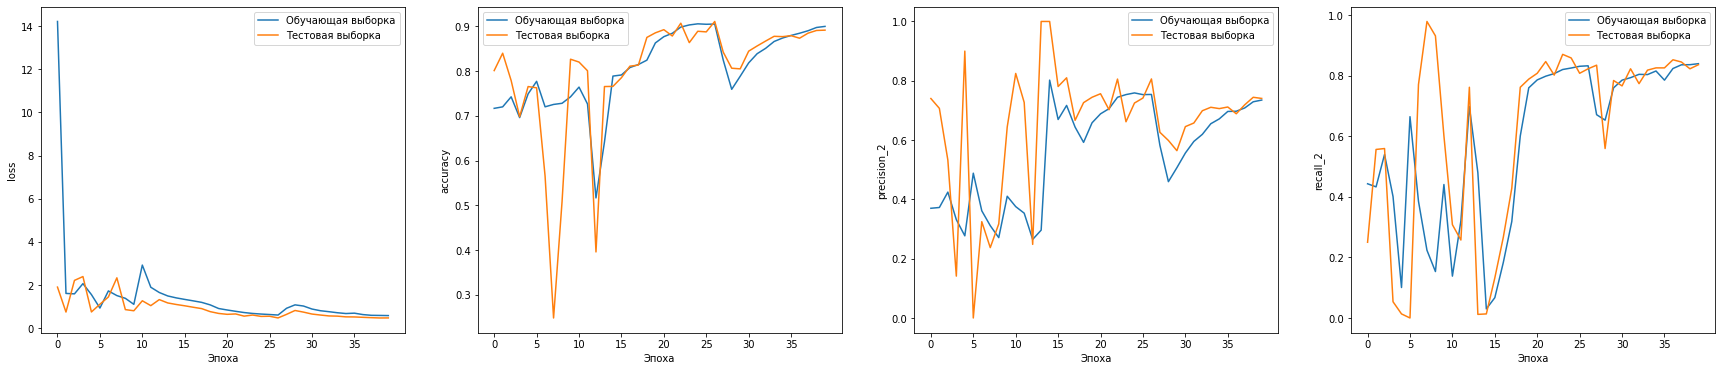

In [ ]:
plot_history(history, 40)

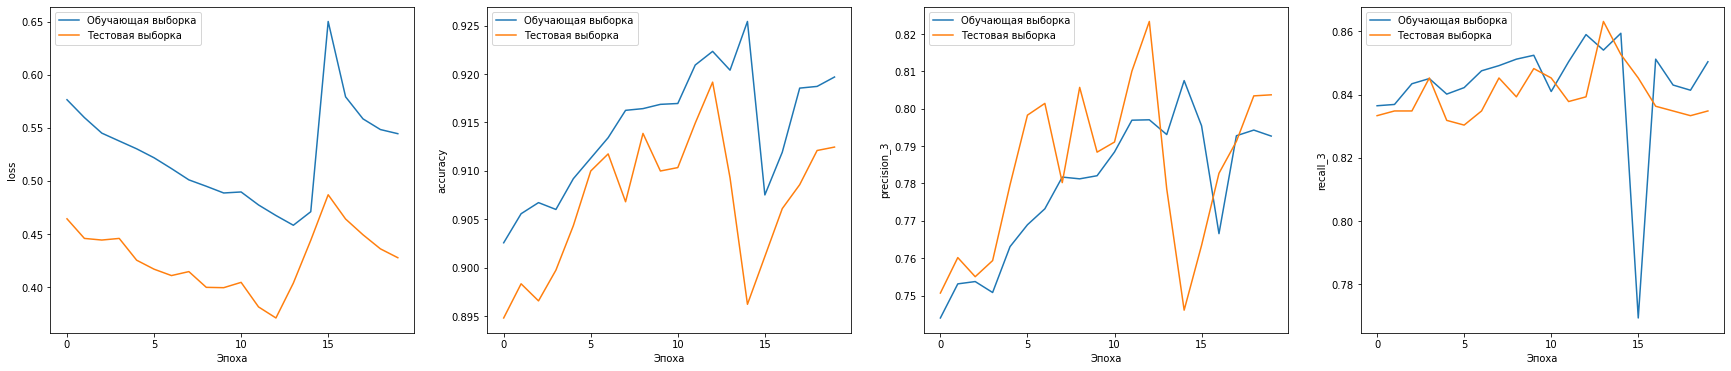

In [ ]:
# графики дообучения
plot_history(history, 20)

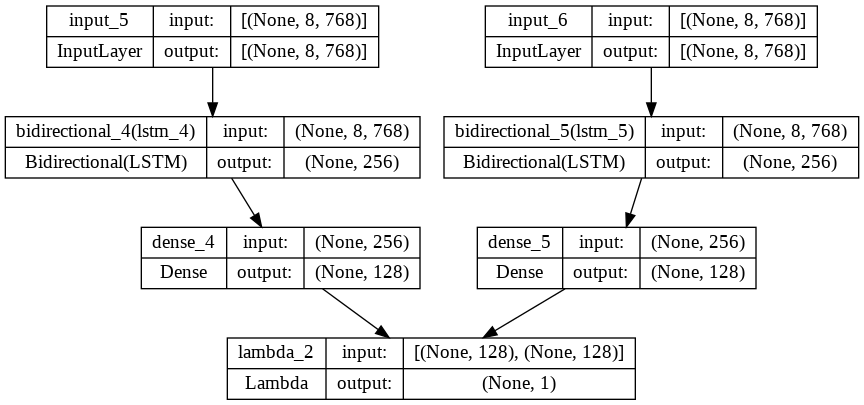

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Embedding

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Similar_company/train_data.csv')

#### Undersampling обучающей выборки

In [ ]:
df_for_tfidf = np.hstack([df.name_1.values, df.name_2.values])

In [ ]:
tfv = TfidfVectorizer(min_df=5, max_df=2000)
tfv.fit(df_for_tfidf)
dict_words = tfv.vocabulary_
key_words = dict_words.keys()

In [ ]:
def frequency_filter(df, key_words):
    labels = []
    for name_1, name_2, dub in df.values:
        n=0
        for word in name_1.lower().split():        
            if (word in key_words) and (word in name_2.lower().split()): 
                n+=1
        if n > 0:
            labels.append(1)
        else:
            labels.append(0)
    df['predict'] = labels
    return df

In [ ]:
df_after_tfidf = frequency_filter(df, key_words)

In [ ]:
for_train = df.loc[df.is_duplicate==1, ['name_1', 'name_2', 'is_duplicate']]

In [ ]:
train = df_after_tfidf.loc[(df_after_tfidf.predict==1)&(df_after_tfidf.is_duplicate==0), ['name_1', 'name_2', 'is_duplicate']]

In [ ]:
train = train.append(for_train)

In [ ]:
print(train.loc[train.is_duplicate==0].shape[0])
print(train.loc[train.is_duplicate==1].shape[0])

11047
3118


In [ ]:
train.head()

,name_1,name_2,is_duplicate
46,Troy Container Line Ltd,Binex Line Corp,0
48,Hua Nan Commercial Bank,Eastman Shanghai Chemical Commercial Co Ltd,0
67,Emo Trans Inc,Ege Trans,0
99,Hellmann Worldwide Logistics,Pegasus Worldwide Logistics Ny Inc,0
291,Miju Components Private Ltd,Matrix Components,0


#### Токенизация

In [ ]:
# Соединяем все названия в один текст
words1=''
for name_1, name_2 in df.iloc[:100000, :2].values:
    words1 = words1 + name_1 + ' ' + name_2 + ' '

words2=''
for name_1, name_2 in df.iloc[100000:200000, :2].values:
    words2 = words2 + name_1 + ' ' + name_2 + ' '

words3=''
for name_1, name_2 in df.iloc[200000:300000, :2].values:
    words3 = words3 + name_1 + ' ' + name_2 + ' '

words4=''
for name_1, name_2 in df.iloc[300000:, :2].values:
    words4 = words4 + name_1 + ' ' + name_2 + ' '

In [ ]:
words = words1 + ' ' + words2 + ' ' + words3 + ' ' + words4

In [ ]:
maxWord = 100000
# Создадим словарь
tokenizer = Tokenizer(num_words=maxWord, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', 
                      char_level=False, oov_token = 'unknown')

tokenizer.fit_on_texts([words])

In [ ]:
# Перемешиваем выборку
train = train.sample(frac=1)

In [ ]:
# преобразовываем названия в последовательность индексов
train_token_1 = tokenizer.texts_to_sequences(train['name_1']) 
train_token_2 = tokenizer.texts_to_sequences(train['name_2']) 


In [ ]:
# преобразуем все списки к одному размеру
train_1 = np.zeros((train.shape[0], 8))
for i, name in enumerate(train_token_1):
    if len(name) > 8:
        name = name[:8]
        train_1[i, :len(name)] = name
    else:
        train_1[i, :len(name)] = name

train_2 = np.zeros((train.shape[0], 8))
for i, name in enumerate(train_token_2):
    if len(name) > 8:
        name = name[:8]
        train_2[i, :len(name)] = name
    else:
        train_2[i, :len(name)] = name

#### Обучение модели

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Bidirectional, Add, Activation, Lambda, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from keras import regularizers
import keras.backend as K
import tensorflow as tf

In [ ]:
from keras import backend as K


def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


@tf.function
def cosine_vectorized(vec):
    array1, array2 = vec
    sumyy = K.sum(array2**2, axis=1, keepdims=1)
    sumxx = K.sum(array1**2, axis=1, keepdims=1)
    sumxy = K.dot(array1, K.transpose(array2))
    sumxy = tf.linalg.diag_part(sumxy)
    sumxy = tf.reshape(sumxy, [-1,1])
    return K.abs(sumxy/K.sqrt(sumxx))/K.sqrt(sumyy)




##### Один слой LSTM, длина эмбеддингов 100

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 100, input_length=8)(input_1)

x1 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='sigmoid',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 100, input_length=8)(input_2)

x2 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='sigmoid',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_v2.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
model.fit([train_1, train_2], train.is_duplicate.values, epochs=40, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2.5}, callbacks=callbacks)

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9779 - precision_3: 0.9190 - recall_3: 0.9868
Epoch 1: val_loss improved from inf to 0.14955, saving model to /content/drive/MyDrive/Similar_company/best_v2.hdf5
237/237 [==============================] - 68s 247ms/step - loss: 0.1255 - accuracy: 0.9779 - precision_3: 0.9190 - recall_3: 0.9868 - val_loss: 0.1496 - val_accuracy: 0.9626 - val_precision_3: 0.9098 - val_recall_3: 0.9215 - lr: 1.0000e-04
Epoch 2/40
237/237 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9793 - precision_3: 0.9254 - recall_3: 0.9852
Epoch 2: val_loss improved from 0.14955 to 0.14829, saving model to /content/drive/MyDrive/Similar_company/best_v2.hdf5
237/237 [==============================] - 61s 257ms/step - loss: 0.1233 - accuracy: 0.9793 - precision_3: 0.9254 - recall_3: 0.9852 - val_loss: 0.1483 - val_accuracy: 0.9654 - val_precision_3: 0.9256 - val_recall_3: 0.9167 - lr: 1.0000e-04
Epoch 3/

##### Два слой LSTM, длина эмбеддингов 150

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 150, input_length=8)(input_1)

x1 = (Bidirectional(LSTM(128,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 150, input_length=8)(input_2)

x2 = (Bidirectional(LSTM(128,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v1.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=40, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2.5}, callbacks=callbacks)

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 11.9337 - accuracy: 0.8729 - precision_4: 0.6791 - recall_4: 0.7892
Epoch 1: val_loss improved from inf to 1.23272, saving model to /content/drive/MyDrive/Similar_company/best_emb_v1.hdf5
237/237 [==============================] - 159s 559ms/step - loss: 11.9337 - accuracy: 0.8729 - precision_4: 0.6791 - recall_4: 0.7892 - val_loss: 1.2327 - val_accuracy: 0.9636 - val_precision_4: 0.9177 - val_recall_4: 0.9247 - lr: 0.0010
Epoch 2/40
237/237 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.9451 - precision_4: 0.8236 - recall_4: 0.9518
Epoch 2: val_loss improved from 1.23272 to 0.55359, saving model to /content/drive/MyDrive/Similar_company/best_emb_v1.hdf5
237/237 [==============================] - 130s 549ms/step - loss: 0.8872 - accuracy: 0.9451 - precision_4: 0.8236 - recall_4: 0.9518 - val_loss: 0.5536 - val_accuracy: 0.9615 - val_precision_4: 0.9081 - val_recall_4: 0.9263 - lr: 0.0010
Epoc

In [ ]:
#Функция выводит графики обучения модели
def plot_history(history, num_epoch):
  plt.figure(figsize=(30, 6))
  name = list(history.history.keys())
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(history.history[name[i]])
    plt.plot(history.history[name[i+4]])
    plt.xlabel("Эпоха")
    plt.ylabel("{}".format(name[i]))
    plt.xticks(range(0,num_epoch, 5))
    plt.legend(['Обучающая выборка','Тестовая выборка'])
  plt.show()

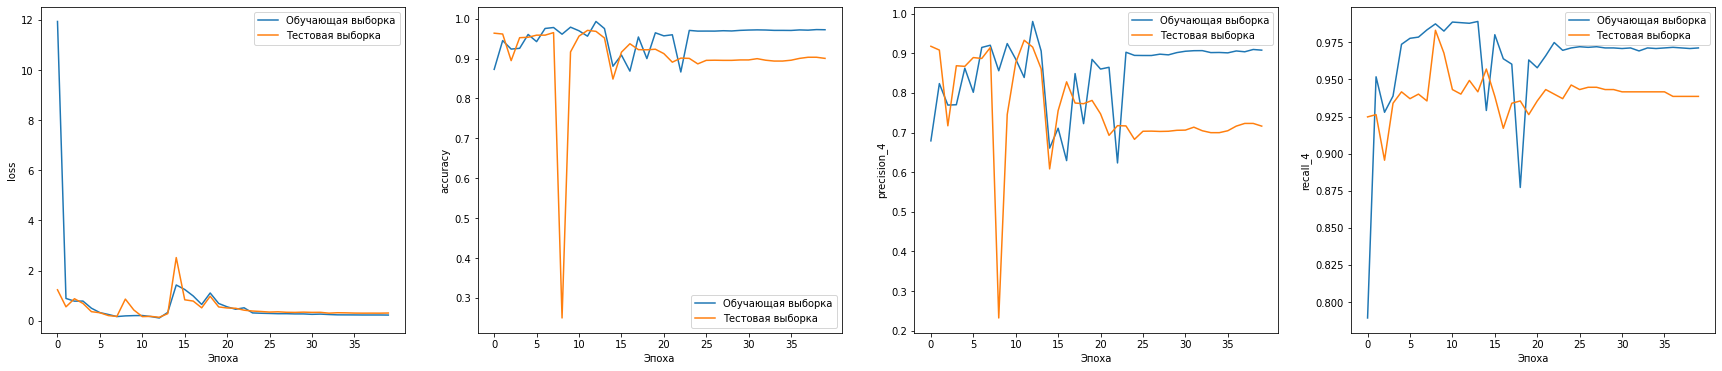

In [ ]:
plot_history(history, 40)

##### Два слой LSTM, длина эмбеддингов 50

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 50, input_length=8)(input_1)

x1 = (Bidirectional(LSTM(128,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 50, input_length=8)(input_2)

x2 = (Bidirectional(LSTM(128,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v2.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=40, batch_size=48, validation_split=0.2, class_weight={0:1, 1:3}, callbacks=callbacks)

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 13.4207 - accuracy: 0.8474 - precision_5: 0.6185 - recall_5: 0.7807
Epoch 1: val_loss improved from inf to 3.68019, saving model to /content/drive/MyDrive/Similar_company/best_emb_v2.hdf5
237/237 [==============================] - 109s 327ms/step - loss: 13.4207 - accuracy: 0.8474 - precision_5: 0.6185 - recall_5: 0.7807 - val_loss: 3.6802 - val_accuracy: 0.7116 - val_precision_5: 0.4425 - val_recall_5: 0.9816 - lr: 0.0010
Epoch 2/40
237/237 [==============================] - ETA: 0s - loss: 1.8558 - accuracy: 0.9582 - precision_5: 0.8748 - recall_5: 0.9428
Epoch 2: val_loss improved from 3.68019 to 1.01017, saving model to /content/drive/MyDrive/Similar_company/best_emb_v2.hdf5
237/237 [==============================] - 76s 321ms/step - loss: 1.8558 - accuracy: 0.9582 - precision_5: 0.8748 - recall_5: 0.9428 - val_loss: 1.0102 - val_accuracy: 0.9513 - val_precision_5: 0.9039 - val_recall_5: 0.8817 - lr: 0.0010
Epoch

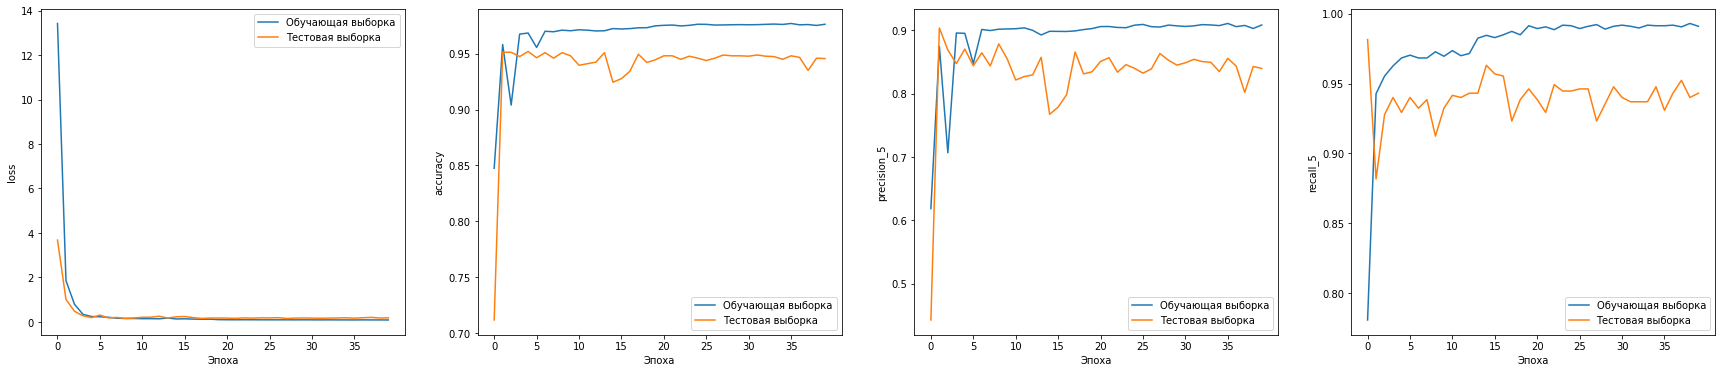

In [ ]:
plot_history(history, 40)

##### Один слой LSTM, длина эмбеддингов 150

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 50, input_length=8)(input_1)

x1 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 50, input_length=8)(input_2)

x2 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v3.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=40, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2}, callbacks=callbacks)

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 6.9867 - accuracy: 0.8562 - precision_6: 0.6620 - recall_6: 0.6940
Epoch 1: val_loss improved from inf to 2.37251, saving model to /content/drive/MyDrive/Similar_company/best_emb_v3.hdf5
237/237 [==============================] - 61s 173ms/step - loss: 6.9867 - accuracy: 0.8562 - precision_6: 0.6620 - recall_6: 0.6940 - val_loss: 2.3725 - val_accuracy: 0.9612 - val_precision_6: 0.9031 - val_recall_6: 0.9309 - lr: 0.0010
Epoch 2/40
237/237 [==============================] - ETA: 0s - loss: 1.5281 - accuracy: 0.9265 - precision_6: 0.7910 - recall_6: 0.9003
Epoch 2: val_loss improved from 2.37251 to 1.06219, saving model to /content/drive/MyDrive/Similar_company/best_emb_v3.hdf5
237/237 [==============================] - 43s 181ms/step - loss: 1.5281 - accuracy: 0.9265 - precision_6: 0.7910 - recall_6: 0.9003 - val_loss: 1.0622 - val_accuracy: 0.9435 - val_precision_6: 0.8252 - val_recall_6: 0.9570 - lr: 0.0010
Epoch 3/

In [ ]:
model.save_weights('/content/drive/MyDrive/Similar_company/best_emb_v3-1.hdf5')

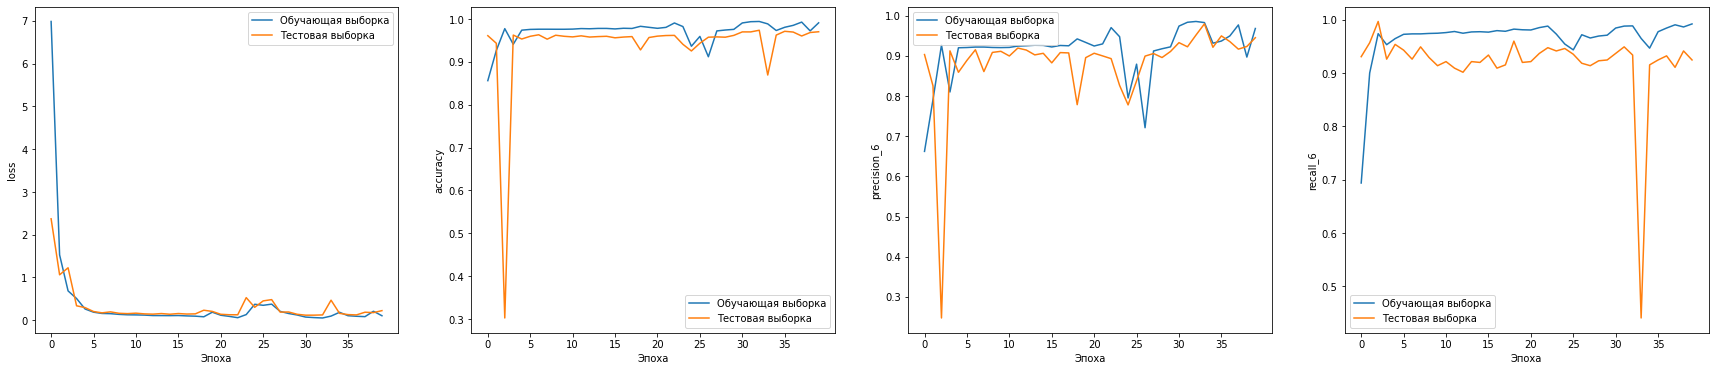

In [ ]:
plot_history(history, 40)

##### Два слой Dense, длина эмбеддингов 100

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 100, input_length=8)(input_1)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Flatten()(x1)

x1 = Dense(256)(x1)  
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128)(x1)  
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(64, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 100, input_length=8)(input_2)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Flatten()(x2)

x2 = Dense(256)(x2)  
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.3)(x2)

x2 = Dense(128)(x2)  
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.3)(x2)

x2 = Dense(64, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v4.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=40, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2}, callbacks=callbacks)

Epoch 1/40
237/237 [==============================] - ETA: 0s - loss: 4.1646 - accuracy: 0.8347 - precision_7: 0.7194 - recall_7: 0.3948
Epoch 1: val_loss improved from inf to 2.57796, saving model to /content/drive/MyDrive/Similar_company/best_emb_v4.hdf5
237/237 [==============================] - 66s 264ms/step - loss: 4.1646 - accuracy: 0.8347 - precision_7: 0.7194 - recall_7: 0.3948 - val_loss: 2.5780 - val_accuracy: 0.9241 - val_precision_7: 0.7774 - val_recall_7: 0.9386 - lr: 0.0010
Epoch 2/40
237/237 [==============================] - ETA: 0s - loss: 1.6362 - accuracy: 0.9594 - precision_7: 0.9003 - recall_7: 0.9149
Epoch 2: val_loss improved from 2.57796 to 1.02368, saving model to /content/drive/MyDrive/Similar_company/best_emb_v4.hdf5
237/237 [==============================] - 66s 278ms/step - loss: 1.6362 - accuracy: 0.9594 - precision_7: 0.9003 - recall_7: 0.9149 - val_loss: 1.0237 - val_accuracy: 0.9580 - val_precision_7: 0.8746 - val_recall_7: 0.9539 - lr: 0.0010
Epoch 3/

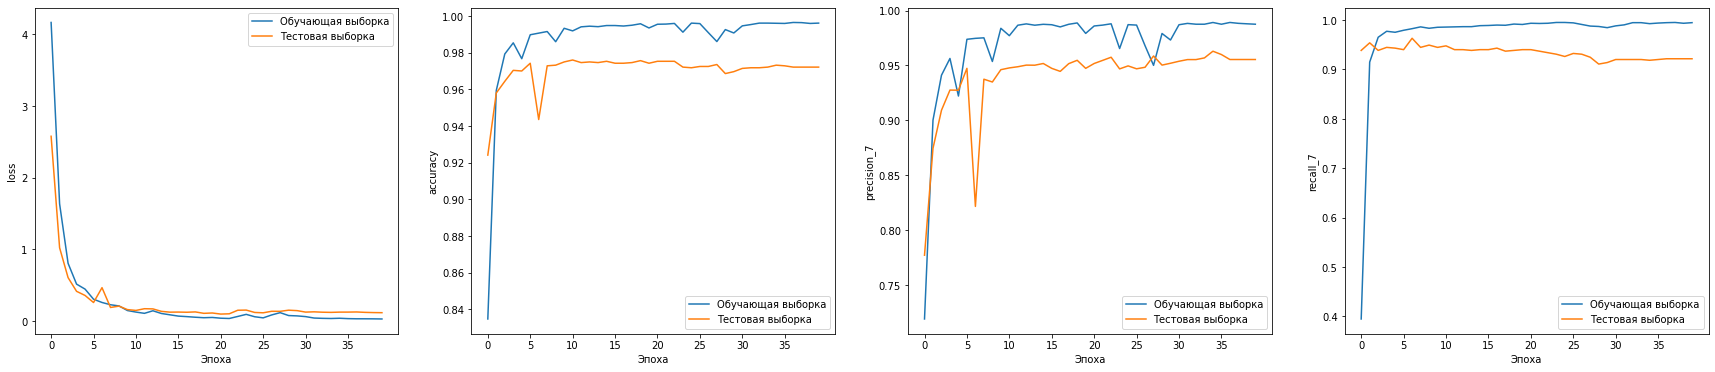

In [ ]:
plot_history(history, 40)

##### Один слой Dense, длина эмбеддингов 100

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 100, input_length=8)(input_1)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Flatten()(x1)

x1 = Dense(128)(x1)  
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(64, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = Embedding(maxWord, 100, input_length=8)(input_2)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Flatten()(x2)

x2 = Dense(128)(x2)  
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.3)(x2)

x2 = Dense(64, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v5.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=20, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2}, callbacks=callbacks)

Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 4.5844 - accuracy: 0.8361 - precision_10: 0.7938 - recall_10: 0.3340
Epoch 1: val_loss improved from inf to 3.10755, saving model to /content/drive/MyDrive/Similar_company/best_emb_v5.hdf5
237/237 [==============================] - 64s 255ms/step - loss: 4.5844 - accuracy: 0.8361 - precision_10: 0.7938 - recall_10: 0.3340 - val_loss: 3.1076 - val_accuracy: 0.9068 - val_precision_10: 0.7516 - val_recall_10: 0.8879 - lr: 0.0010
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 2.3941 - accuracy: 0.9482 - precision_10: 0.8859 - recall_10: 0.8747
Epoch 2: val_loss improved from 3.10755 to 1.62203, saving model to /content/drive/MyDrive/Similar_company/best_emb_v5.hdf5
237/237 [==============================] - 61s 255ms/step - loss: 2.3941 - accuracy: 0.9482 - precision_10: 0.8859 - recall_10: 0.8747 - val_loss: 1.6220 - val_accuracy: 0.9562 - val_precision_10: 0.8717 - val_recall_10: 0.9493 - lr: 0.0

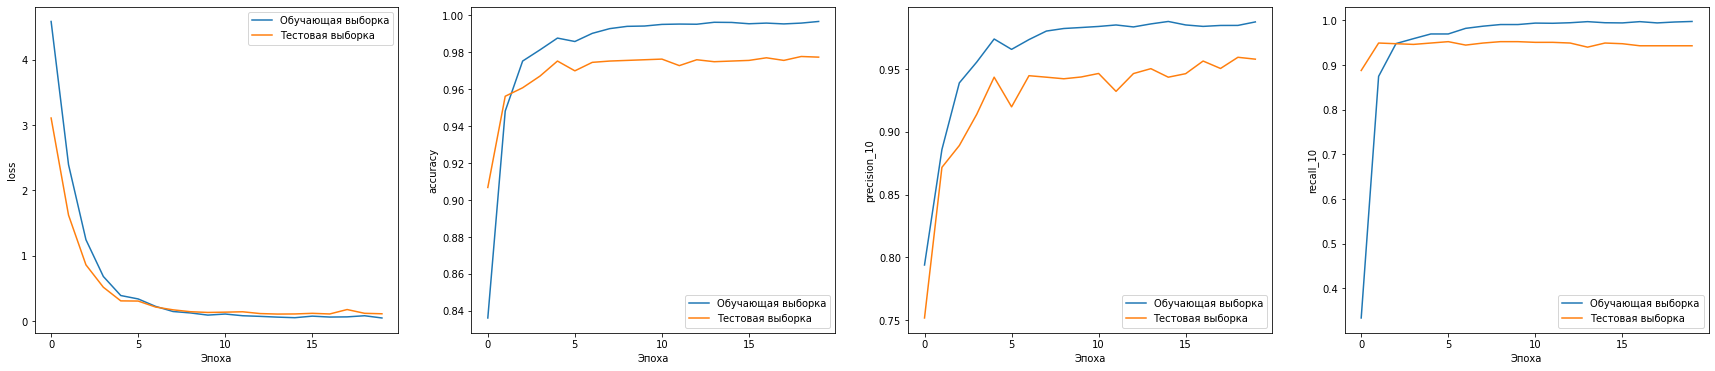

In [ ]:
plot_history(history, 20)

In [ ]:
model.save_weights('/content/drive/MyDrive/Similar_company/best_emb_v5.hdf5')

##### Один слой Dense (меньше нейронов), длина эмбеддингов 50

In [ ]:
input_1 = Input(8)
input_2 = Input(8)


x1 = Embedding(maxWord, 50, input_length=8)(input_1)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Flatten()(x1)

x1 = Dense(64)(x1)  
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(32, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            

x2 = Embedding(maxWord, 50, input_length=8)(input_2)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Flatten()(x2)

x2 = Dense(64)(x2)  
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.3)(x2)

x2 = Dense(32, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    

out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Similar_company/best_emb_v6.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
history = model.fit([train_1, train_2], train.is_duplicate.values, epochs=20, batch_size=48, validation_split=0.2, class_weight={0:1, 1:2}, callbacks=callbacks)

Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 3.4939 - accuracy: 0.7819 - precision_11: 0.4767 - recall_11: 0.0166
Epoch 1: val_loss improved from inf to 2.91438, saving model to /content/drive/MyDrive/Similar_company/best_emb_v6.hdf5
237/237 [==============================] - 36s 143ms/step - loss: 3.4939 - accuracy: 0.7819 - precision_11: 0.4767 - recall_11: 0.0166 - val_loss: 2.9144 - val_accuracy: 0.7762 - val_precision_11: 0.6076 - val_recall_11: 0.0737 - lr: 0.0010
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 3.1965 - accuracy: 0.7863 - precision_11: 0.6066 - recall_11: 0.0519
Epoch 2: val_loss improved from 2.91438 to 2.65296, saving model to /content/drive/MyDrive/Similar_company/best_emb_v6.hdf5
237/237 [==============================] - 34s 144ms/step - loss: 3.1965 - accuracy: 0.7863 - precision_11: 0.6066 - recall_11: 0.0519 - val_loss: 2.6530 - val_accuracy: 0.8115 - val_precision_11: 0.6466 - val_recall_11: 0.3963 - lr: 0.0

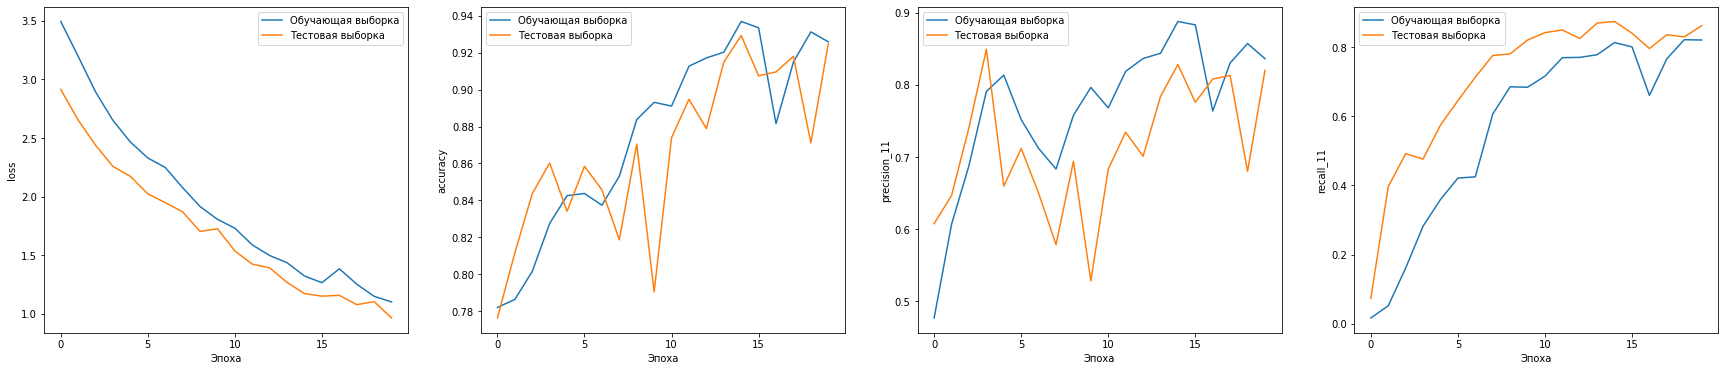

In [ ]:
plot_history(history, 20)